# Automatic detection of outliers in a dataset of images
For explanations on this code, check out https://www.lemurnet.org/blog_cleaning_dataset/

In [1]:
import keras
import sklearn
import numpy as np
import os
import pandas as pd
import seaborn as sns

from keras.applications.mobilenetv2 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model, load_model
from keras.layers import GlobalAveragePooling2D
from keras.utils import Sequence

from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest

from multiprocessing import Pool, cpu_count

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/home/pmd/anaconda3/envs/tf_p36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [6]:
base_dir = "/path/to/your/dataset"
classes = os.listdir(base_dir)
classes.sort()

In [5]:
model = MobileNetV2(
    input_shape=(224, 224, 3), weights="imagenet", include_top=False, pooling="avg"
)

In [ ]:
files = []
for root, directories, filenames in os.walk(base_dir):
    files.extend(filenames)
    
# each picture name must have format "genus species.xx.jpg", eg "varecia rubra.1.jpg", "varecia rubra.2.jpg"...
df = pd.DataFrame(files, columns=["image"])
df["species"] = df.apply(lambda row: row.image.split(".")[0], axis=1)
df["path"] = df.apply(
    lambda row: os.path.join(base_dir, row.species, row.image), axis=1
)
df["genus"] = df.species.apply(lambda x: x.split()[0])

families = {
    "propithecus": "indriidae",
    "mirza": "cheirogaleidae",
    "eulemur": "lemuridae",
    "phaner": "cheirogaleidae",
    "varecia": "lemuridae",
    "lemur": "lemuridae",
    "indri": "indriidae",
    "microcebus": "cheirogaleidae",
    "lepilemur": "lepilemuridae",
    "avahi": "indriidae",
    "daubentonia": "daubentoniidae",
    "hapalemur": "lemuridae",
    "cheirogaleus": "cheirogaleidae",
    "prolemur": "lemuridae",
}

df["family"] = df.genus.apply(lambda x: families[x])

In [18]:
class LemurSeq(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return len(self.x) // self.batch_size

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size : (idx + 1) * self.batch_size]

        return (
            np.array(
                [
                    preprocess_input(
                        img_to_array(load_img(file_name, target_size=(224, 224)))
                    )
                    for file_name in batch_x
                ]
            ),
            np.array(batch_y),
        )

In [19]:
lemseq = LemurSeq(df.path, df.species, 49)
assert lemseq.__len__() * lemseq.batch_size == len(df)

features = model.predict_generator(
    lemseq, use_multiprocessing=True, workers=cpu_count()
)

feature_columns = ["feature_%s" % i for i in range(features.shape[1])]
df = df.join(pd.DataFrame(features, columns=feature_columns))

In [ ]:
tSNE = TSNE(n_components=2).fit_transform(df[feature_columns])

tSNE_columns = [ "tSNE_%s" % j for j in range(tSNE.shape[1]) ]
for j, col_name in enumerate(tSNE_columns):
    df[col_name] = tSNE[:,j]

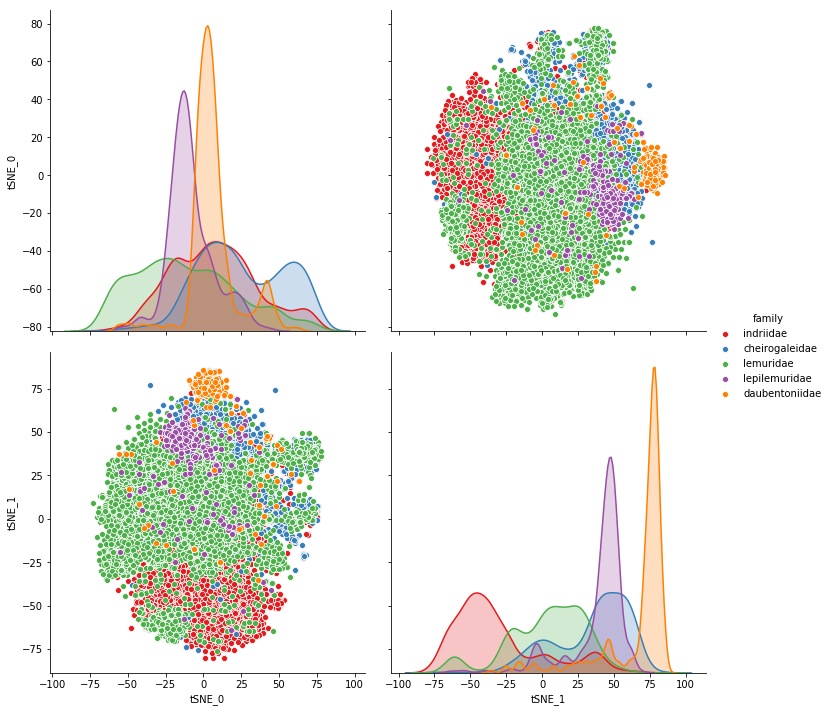

In [5]:
sns.pairplot(
    df,
    x_vars=tSNE_columns,
    y_vars=tSNE_columns,
    hue="family",
    palette=sns.color_palette("Set1"),
    height=5,
)

In [32]:
clf = IsolationForest(n_jobs=-1, behaviour="new", contamination="auto")

for s, X in df.groupby("species"):
    df.loc[df.species == s, "outlier"] = clf.fit_predict(X[tSNE_columns])

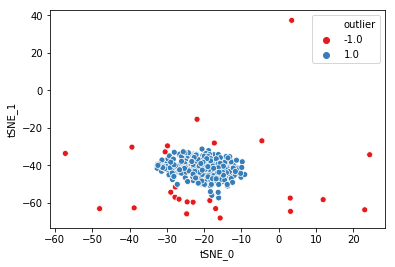

In [31]:
sns.scatterplot(
    data=df[df.species == 'indri indri'],
    x='tSNE_0',
    y='tSNE_1',
    hue="outlier",
    palette=sns.color_palette("Set1", 2)
)

In [ ]:
df[df.outlier < 0].path.apply(lambda x: os.remove(x))